# Assignment 2

__Simon Karumbi__   
s3455453

### Honour Code
I solemnly swear that I have not discussed my assignment solutions with anyone in any way and the solutions I am submitting are my own personal work.

_Simon Karumbi_

In [1]:
import pandas as pd
import numpy as np
import os, ssl

# setting all the columns to be visible
pd.set_option('display.max_columns', None) 

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
Q1 = pd.read_csv('A2_Q1.csv')
print(Q1.shape)
Q1.head(5)

(20, 6)


,ID,Age,Education,Marital_Status,Occupation,Annual_Income
0,1,39,bachelors,never married,professional,high
1,2,50,doctorate,married,professional,mid
2,3,18,high school,never married,agriculture,low
3,4,30,bachelors,married,professional,mid
4,5,37,high school,married,agriculture,mid


In [3]:
# removing ID as it is a redundant feature
Q1.drop(columns = 'ID', inplace = True) 

# Question 1
### Part A
Compute the impurity of the target feature. We will do this by using the Gini index. 

In [4]:
# Defining the target feature
target = 'Annual_Income'
probs = Q1[target].value_counts(normalize = True)

gini_index = 1 - np.sum(np.square(probs))
print(f'Impurity using the Gini index: {gini_index}')

Impurity using the Gini index: 0.5549999999999999


### Part B
Now that we have calculated the Gini index of the target feature, we need to decide which feature set to split the decision tree by. We need to work on the `Age` continuous feature.

In [5]:
# Creating a Data Frame to hold information about choosing the root node of the Decision Tree
df_splits = pd.DataFrame(columns = ['split','remainder','information_gain','is_optimal'])

#### Gini index function
Creating a function for computing the gini index of a feature

In [6]:
def compute_gini(feature):
    """
    A function that takes in a feature series and computes the gini index
    """
    
    probs = feature.value_counts(normalize=True)
    impurity = round(1 - np.sum(np.square(probs)), 3)
    
    return(impurity)

#### Remainder function
Creating a function for measuring the remainder entropy of a descriptive feaure

In [7]:
# measuring the remainder entropy for each of the levels in a feature
def remainder_gini(df, target_feature, descriptive_feature):
    """
    Calculates the remainder entropy of each level of the descriptive feature through the gini index 
    """

    # Initialising the remainder entropy value for each descriptive feature
    rem = 0

    # Calculate the weighted entropy of each unique level of a descriptive feature
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        target_impurity = compute_gini(df_feature_level[target_feature])
        partition_weight = len(df_feature_level) /(len(df))
        
        # Calculate the weighted remainder
        rem = round(rem + partition_weight * target_impurity, 3)
    return(rem)

#### Information Gain function
Creating a function for computing the Information Gain for a descriptive feature

In [8]:
def information_gain_gini(df, target_feature, descriptive_feature):
    
    """
    Calculates the information gain of a particular descriptive feature, measured against a target feature within a dataset
    """
    
    # Calculate the impurity of the target feature
    target_impurity = compute_gini(df[target_feature])
    
    # Calculate the remainder of the descriptive feature
    rem = remainder_gini(df, target_feature, descriptive_feature)
    
    # Calculate the information gain of each descriptive feature, rounding to 3 decimal places
    information_gain = round(target_impurity - rem, 3)
    
    return(information_gain)

#### Dealing with the Age continuous variable
Sorting the dataframe by age, to notice any changes in the target feature. Storing the split candidates and then performing a information gain computation to find best candidate

In [9]:
# Order df by age column
Q1.sort_values(by = 'Age', inplace = True)

# Calculate the information gain for each split, and select the highest split
split_values = []
Q1 = Q1.reset_index(drop = True)

# For each age value change in the data, if the target feature also changes, add the age to be tested as a split candidate
for index, row in Q1.iterrows():
    if (index > 1 and Q1.loc[index, target] != Q1.loc[index - 1, target]):
        split_values.append(Q1.loc[index, 'Age'])

In [10]:
# Finding the optimal age bin
optimal = []

for split in split_values:
    # create a copy of the Q1 dataset each time
    Q1_copy = Q1.copy()
    
    # creating discretised bins on each of the split candidates found earlier. Increasing max age as we don't want it to be inclusive on the right hand side
    Q1_copy['Age'] = pd.cut(x = Q1_copy['Age'], bins = [0,split, max(Q1_copy['Age']) + 1], right = False, labels = ['less than ' + split.astype(str), 'greater than or equal to ' + split.astype(str)])
    
    # calculating the information gain for each of the split candidates
    optimal.append([split, information_gain_gini(Q1_copy, target, 'Age')])

# Printing the age bins and their respective information gains, we can see that splitting by <25 and >=25 is the optimal solution
optimal

[[25, 0.202], [29, 0.195], [39, 0.026], [44, 0.082]]

In [11]:
# Creating a new column for binned age, so that we know the original values for sanity checks
Q1['Age_Binned'] = pd.cut(x = Q1['Age'], bins = [0, 25, max(Q1['Age'] + 1)], right = False, labels =['< 25', '>=25'])

#### Adding all the information to the Data Frame
Now we iterate through each descriptive feature, excluding the target feature and the age column (we have binned age instead) and add it to the Data Frame

In [12]:
# Dropping the target feature and age, as the age is already binned
for feature in Q1.drop(columns = [target, 'Age']).columns:
    df_splits.loc[len(df_splits)] = [feature, remainder_gini(Q1, target, feature), information_gain_gini(Q1, target, feature), False]


In [13]:
# Calculating the optimal split candidate by looking at the maximum information gain
for index, row in df_splits.iterrows():
    if(df_splits.loc[index, 'information_gain'] == max(df_splits['information_gain'])):
        df_splits.loc[index, 'is_optimal'] = True
        
df_splits

,split,remainder,information_gain,is_optimal
0,Education,0.537,0.018,False
1,Marital_Status,0.468,0.087,False
2,Occupation,0.433,0.122,False
3,Age_Binned,0.353,0.202,True


### Part C
Assume `Education` is the root node for the Decision Tree

In [14]:
df_prediction = pd.DataFrame(columns = ['Leaf_Condition', 'Low_Income_Prob', 'Mid_Income_Prob', 'High_Income_Prob', 'Leaf_Prediction'])

In [15]:
# Iterate over unique values of Education
for level in Q1['Education'].unique():
    # Create a list to insert elements to add to the Data Frame
    pred = list()
    
    # Append the condition to the list and create a list for numeric vals
    pred.append('Education == ' + level)
    
    # For each low, med and high, calculate the probablity of a correct prediction
    for target_level in ['low', 'mid', 'high']:
        correct = len(Q1[(Q1['Education'] == level) & (Q1[target] == target_level)])
        total = len(Q1[Q1['Education'] == level])

        # Calculating the probablity of successfully predicting the target feature
        pred.append(correct/total)
    
    # Obtaining the index of the highest probability
    index  = pred.index(max(pred[1:-1]))
    
    # Case statement for appending the prediction value
    if(index == 1):
        pred.append('low')
    if(index == 2):
        pred.append('mid')
    if(index == 3):
        pred.append('high')
    
    # Adding the rows to the Data Frame
    df_prediction.loc[len(df_prediction)] = pred

In [16]:
# Printing the Data Frame
df_prediction

,Leaf_Condition,Low_Income_Prob,Mid_Income_Prob,High_Income_Prob,Leaf_Prediction
0,Education == high school,0.250,0.500,0.25,mid
1,Education == bachelors,0.125,0.625,0.25,mid
2,Education == doctorate,0.000,0.750,0.25,mid


# Question 2
### Part A
Solving for the confusion Matrix

In [17]:
Q2 = pd.read_csv('A2_Q2.csv')

In [18]:
print(Q2.shape)
Q2.head()

(30, 3)


,ID,Target,Score
0,1,False,0.46
1,2,False,0.14
2,3,False,0.48
3,4,True,0.91
4,5,False,0.24


In [19]:
# Removing the redundant feature
Q2.drop(columns = 'ID', inplace = True)

In [20]:
score = np.array(Q2['Score'])
Q2['Score_Threshhold'] = score > 0.5

confusion_matrix = pd.crosstab(Q2['Target'], Q2['Score_Threshhold'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  False  True 
Actual                 
False         11      6
True           4      9


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix, annot=True, linecolor = 'white', linewidth = 0.5)
plt.title('Confusion Matrix')
plt.show()

<Figure size 640x480 with 2 Axes>

### Part B
Computing the following metrics

In [22]:
FP = np.sum(confusion_matrix, axis = 0) - np.diag(confusion_matrix) 
FN = np.sum(confusion_matrix, axis = 1) - np.diag(confusion_matrix) 
TP = np.diag(confusion_matrix)
TN = np.sum(confusion_matrix) - (FP + FN + TP)

#### Error Rate
Calculated by False Positives and False Negatives divided by the total dataset (TP + FP + TN + FN)

In [23]:
error = np.mean((FP + FN)/ (TP + FP + TN + FN))
print(f'The error rate of this dataset is: {round(error, 3)}')

The error rate of this dataset is: 0.667


#### True Positive Rate
Calculated by dividing True Positives by total amount of Positives (TP and FN) in the dataset

In [24]:
tpr = np.mean(TP/(TP + FN))
print(f'The True Positive Rate of this dataset is {round(tpr, 3)}')

The True Positive Rate of this dataset is 0.67


#### False Positive Rate
Calculated by dividing the False Negative by the total amount of Negative Predicitons (TN and FP), which can be found by subtracting True Negative divided by TN and FP, and subtracting from 1.

In [25]:
fpr = np.mean(1 - TN/(TN + FP))
print(f'The False Positive Rate of this dataset is: {fpr}')

The False Positive Rate of this dataset is: 0.5


#### Precision
Calculated by dividing True Positive by total amount of Positive Predictions (TP and FP)

In [26]:
prec = np.mean(TP/(TP + FP))
print(f'The Precision of this dataset is {round(prec,3)}')

The Precision of this dataset is 0.667


#### F$_1$ Score
Calculated using the equation $𝐹_1=2\times \frac{𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛×𝑟𝑒𝑐𝑎𝑙𝑙}{𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑟𝑒𝑐𝑎𝑙𝑙}$

In [27]:
f1 = 2 * (prec * tpr) / (prec + tpr)
print(f'The F1 score is {round(f1, 3)}')

The F1 score is 0.668


#### Creating a Data Frame to hold the data

In [28]:
metrics = {'Metric' :
          ['Error_Rate', 'True_Positive_Rate', 'Precision', 'F1', 'False_Positive_Rate'], 
           'Value' : [error, tpr, prec, f1, fpr]}

In [29]:
df_metrics = pd.DataFrame(metrics, columns =['Metric', 'Value'])
df_metrics

,Metric,Value
0,Error_Rate,0.666667
1,True_Positive_Rate,0.669683
2,Precision,0.666667
3,F1,0.668172
4,False_Positive_Rate,0.500000


### Part C
Varying the threshhold

In [30]:
df_roc = pd.DataFrame(columns = ['Threshold', 'TPR', 'FPR'])

In [31]:
# Defining the rate as a float
rate = 0.1

# Iterating over 0.1 and 0.9 inclusive
for threshold in range(1, 10):
    # Creating a confusion matrix for the new threshold
    ct = pd.crosstab(Q2['Target'], Q2['Score'] > (threshold * rate))
    
    # Using a more concise way of caluclating of the equations above
    # TP/(TP+FN)
    tpr = round(np.mean(ct[1][1]/(ct[1][1] + ct[1][0])), 3)
    
    # 1 - TN/(TN-FP)
    fpr = round(np.mean(1 - ct[0][0]/(ct[0][0] + ct[0][1])), 3)
    
    # Inserting into the Data Frame
    df_roc.loc[len(df_roc)] = (round(threshold * rate, 3), tpr, fpr)

In [32]:
df_roc

,Threshold,TPR,FPR
0,0.1,0.448,0.000
1,0.2,0.520,0.000
2,0.3,0.545,0.125
3,0.4,0.579,0.182
4,0.5,0.600,0.267
5,0.6,0.667,0.278
6,0.7,0.750,0.318
7,0.8,0.800,0.360
8,0.9,1.000,0.414


### Part D
Displaying an ROC curve

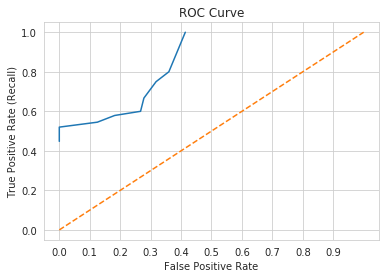

In [33]:
sns.set_style('whitegrid')
plt.plot(df_roc['FPR'], df_roc['TPR'])
plt.plot([0,1], [0,1], linestyle = '--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.xticks(np.arange(0,1, step = 0.1))

plt.ylabel('True Positive Rate (Recall)')
plt.xticks(np.arange(0,1, step = 0.1))

plt.show()